# Group 13 - “CA applied to the Stock Market”

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Preparations

Create network

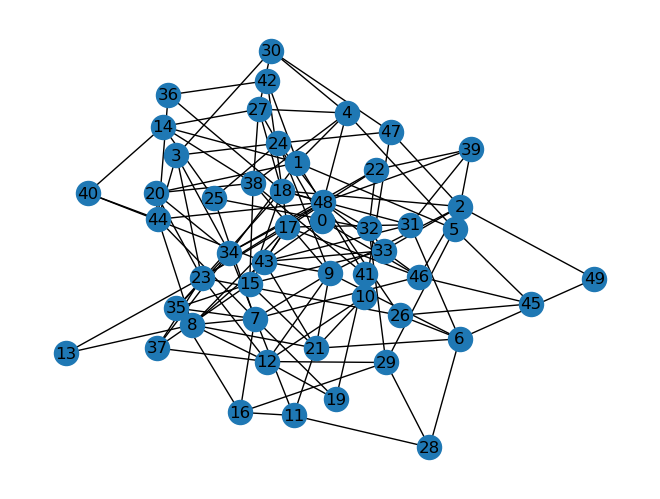

In [18]:
# parameter settings
n = 100  # nodes
p = 8 / n # probability to connect, n * p should be equal to the number 
          # of neighbors in mole field which is 8

# Use NetworkX to create RN network
ER_graph = nx.gnp_random_graph(n, p)

# Visualizing the network
nx.draw(ER_graph, with_labels=True)
plt.show()

Text(0.5, 1.0, 'Erdős_Rényi Model')

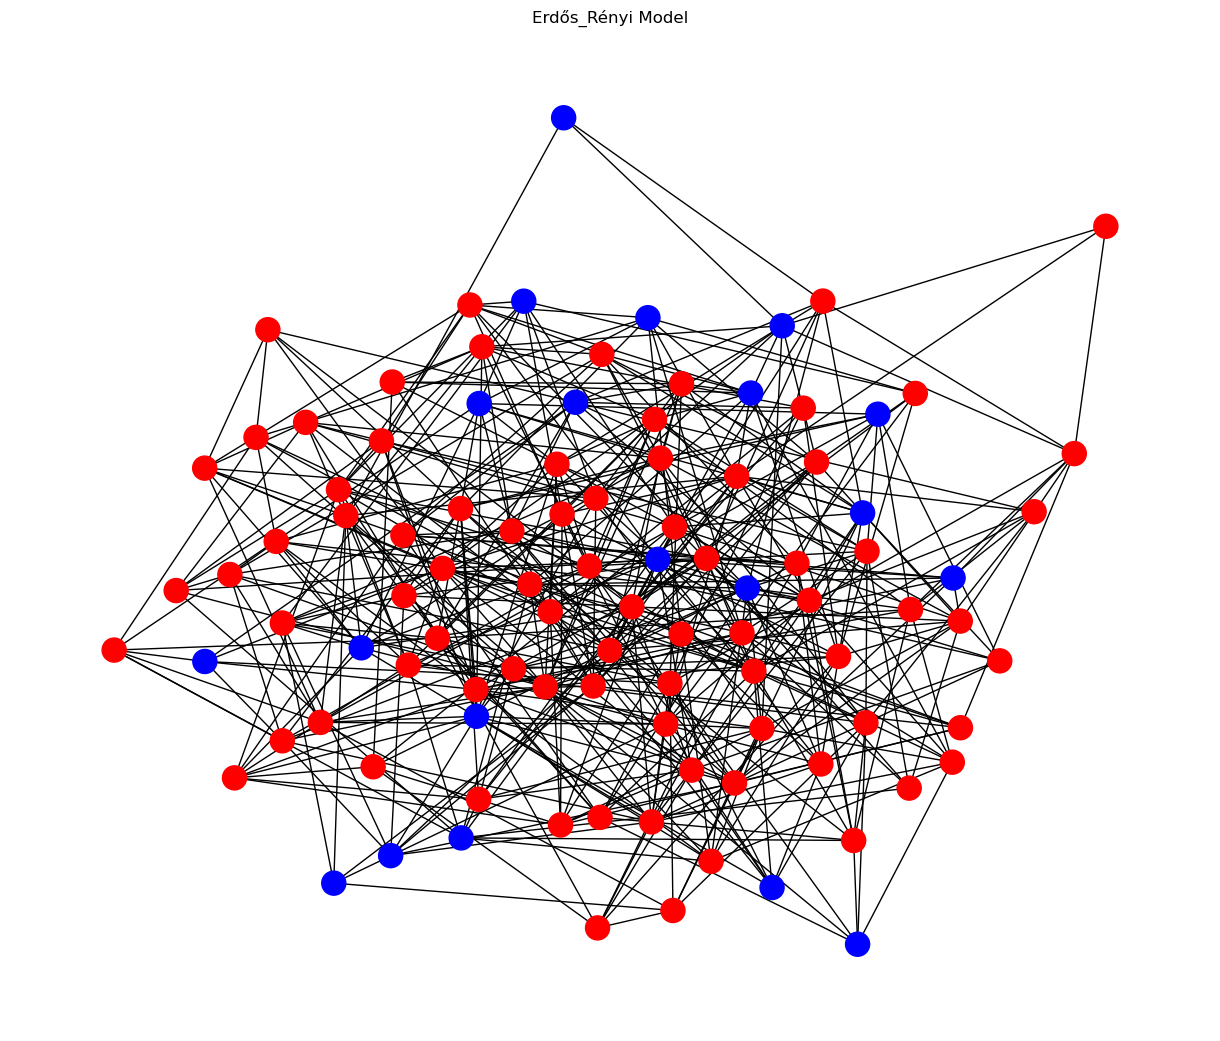

In [20]:
# Assign node type 
alpha_im = 0.2
alpha_fu = 1 - alpha_im
colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes

# 绘制Erdős–Rényi随机图
plt.figure(figsize=(12, 10))
nx.draw(ER_graph, node_color=colors, with_labels=False)
plt.title('Erdős_Rényi Model')

Create a trader class

In [191]:

class Trader:
    def __init__(self, node_id, node_color, graph, parameters):
        """
        Initialize the Trader class.
        :param node_id: Node's ID
        :param node_color: Node's color, representing the Trader's type ('blue' for Imitator, 'red' for Fundamentalist)
        :param graph: The network graph where the node is located.
        """
        self.node_id = node_id
        self.node_color = node_color
        self.type = 'Imitator' if node_color == 'blue' else 'Fundamentalist'
        self.neighbors = list(graph.neighbors(node_id))  # Get the list of neighboring nodes
        self.neighbors_count = len(self.neighbors)  # Number of neighbors
        self.parameters = parameters
        self.trade_level = parameters["trade_level"]
        self.fundamental_value = 100
        # Use normal distribute to create fundamental_values
        #self.fundamental_value = np.random.normal(100, np.sqrt(10))
        self.transaction_quantity = 0  # Initial trading volume is 0
    def fundamentalist_strategy(self, current_price, Mt = 0.05):
        """
        Update the trading quantity for Fundamentalist traders.
        :param current_price: Current price
        :param fundamental_value: Fundamental value
        """
        if self.trade_level == 1:
            self.transaction_quantity = self.fundamental_value - current_price
        elif self.trade_level == 3:
            self.transaction_quantity = (self.fundamental_value * (1 + self.parameters["Cfu"] * np.random.randn())
            - current_price) * Mt

    def imitator_strategy(self, transaction_quantities, Mt = 0.05):
        """
        Update the trading quantity for Imitator traders.
        :param neighbor_transactions: List of neighbor transactions
        """
        neighbor_transactions = []
        for neighbor in self.neighbors:
            neighbor_transactions.append(transaction_quantities[neighbor])
        mean_transaction_quantity = sum(neighbor_transactions) / max(1, len(neighbor_transactions))
        if self.trade_level == 1:
            self.transaction_quantity = mean_transaction_quantity
        elif self.trade_level == 3:
            self.transaction_quantity = mean_transaction_quantity * (1 + self.parameters["Cim"] * np.random.randn()) * Mt

Class test

In [25]:
# Example: Create a Trader instance
# Assuming we have a pre-created NetworkX graph object and a list of node colors

# Choose a node ID
sample_node_id = 21
# Get the node color
sample_node_color = colors[sample_node_id]

# Create a Trader instance
sample_trader = Trader(sample_node_id, sample_node_color, ER_graph)

# Print information about this instance for verification
print(f"Trader ID: {sample_trader.node_id}")
print(f"Trader Type: {sample_trader.type}")
print(f"Trader Neighbor: {sample_trader.neighbors}")
print(f"Trader Neighbors Count: {sample_trader.neighbors_count}")

Trader ID: 21
Trader Type: Fundamentalist
Trader Neighbor: [4, 15, 24, 46, 72, 74, 85, 94, 95, 96]
Trader Neighbors Count: 10


Impletement

In [56]:
# Construct a Trader object for each node in the random graph
traders = [Trader(node_id, color, ER_graph) for node_id, color in enumerate(colors)]

# Print the type and number of neighbors of the first 5 traders
for trader in traders[20:25]:
    print(f"Trader ID: {trader.node_id}, Type: {trader.type}, Trader Fundamental Value: {trader.fundamental_value}")


Trader ID: 20, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 21, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 22, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 23, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 24, Type: Fundamentalist, Trader Fundamental Value: 100


Update price

In [154]:
def update_price(current_price, transaction_quantities, cp, N):
    """
    Update the price based on the  Level I model.

    :param current_price: The price at the current time point
    :param transaction_quantities: List of transaction quantities for all traders at the current time point
    :param cp: Sensitivity of price to excess demand
    :param N: Number of traders
    :return: Updated price
    """
    Qt = sum(transaction_quantities)  # Calculate the total transaction quantity
    price_change = cp * Qt / N  # Calculate price change based on the rule
    new_price = current_price + price_change  # Update the price
    new_price = max(new_price, 0)  # Ensure the price doesn't go below 0
    return new_price

# Example: Update the price
current_price = 105  # Current price
cp = 0.2  # Sensitivity of price to excess demand
N = len(traders)  # Number of traders
transaction_quantities = [trader.transaction_quantity for trader in traders]  # List of transaction quantities for all traders

# Call the function to update the price
new_price = update_price(current_price, transaction_quantities, cp, N)

# Output the new price
print(f"The new price is: {new_price}")


The new price is: 105.0


## Simulate Level I model

In [321]:
#STEP 1: build network
n = 1000  # nodes
p = 8 / n # probability to connect, n * p should be equal to the number 
          # of neighbors in mole field which is 8

# Use NetworkX to create RN network
ER_graph = nx.gnp_random_graph(n, p)
alpha_ims = [0.2, 0.8]
colorsets = {} # different colorsets means different Proportions of different transaction types
for alpha_im in alpha_ims:
    alpha_fu = 1 - alpha_im
    colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes
    colorsets[alpha_im] = colors

In [ ]:
for colors in colorsets.values():
    # Draw Erdős–Rényi random graph
    plt.figure(figsize=(12, 10))
    nx.draw(ER_graph, node_color=colors, with_labels=False)
    plt.title('Erdős_Rényi Model')
    plt.show()

In [322]:
price_historys = {}
for key, colors in colorsets.items():
    parameters_level1 = {
        "trade_level" : 1
    }
    traders = [Trader(node_id, color, ER_graph, parameters_level1) for node_id, color in enumerate(colors)]

    cp = 0.5  # Sensitivity of price to excess demand
    N = len(traders)  # Number of traders

    total_time_steps = 100  # Total time steps
    initial_price = 105  # Initial price
    price_history = [initial_price]
    transaction_quantities = [trader.transaction_quantity for trader in traders]

    for _ in range(total_time_steps):
        # Get the current price
        current_price = price_history[-1]

        # Update traders' transaction quantities
        for trader in traders:
            # For Imitators, we update them based on their neighbors' transaction quantities
            if trader.type == 'Imitator':
                trader.imitator_strategy(transaction_quantities)  # Assuming here that neighbors already contain the corresponding trader objects
            # For Fundamentalist traders, we update them based on the current price and fundamental value
            else:
                trader.fundamentalist_strategy(current_price)

        # Calculate the new price
        transaction_quantities = [trader.transaction_quantity for trader in traders]
        new_price = update_price(current_price, transaction_quantities, cp, len(traders))

        # Update price history
        price_history.append(new_price)
    price_historys[key] = price_history


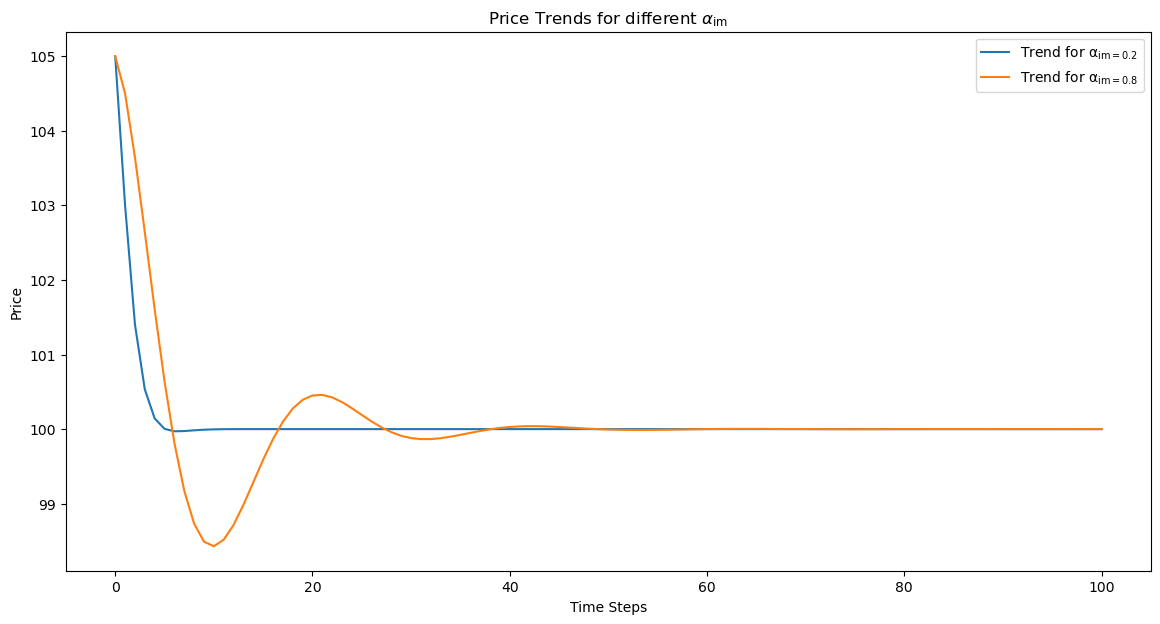

In [323]:
plt.figure(figsize=(14, 7))
for key, values in price_historys.items():
    plt.plot(values, label=r'Trend for $\mathrm{\alpha_{im=' + str(key) + '}}$')
plt.title(r'Price Trends for different $\alpha_{\mathrm{im}}$')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

## Level III model 

Corresponding Formula:  

Price fluctuation level of a stock:

$L^t=\frac{1}{k}\sum_{i=t-k}^{t-1}|P^i-\bar{P}|/\bar{P}$

Current trading activity:  

$M^t(L^t)=\begin{cases}c_lL^t,&L^t\leqslant L_m,\\c_l(-L^t+2L_m)&L^t>L_m,\end{cases}$  

$\eta_{fu}^{t}=1+c_{fu}\phi_{fu}^{t}$  

where $\phi_{fu}^{t}$ is an independent Gaussian random variable with mean 0 and standard
deviation 1 and $c_{fu}$ is a positive parameter indicating the
fundamentalists’ sensitivity to news.
Transaction quantity of fundamentalists:

$\begin{aligned}
q_{i,fu}^{t+1}& =V_{i,fu}^{t+1}M^{t+1}  \\
&=(F\eta_{fu}^{t+1}-P^{t})M^{t+1}
\end{aligned}$

Transaction quantity of imitators:

$\begin{aligned}q_{i,im}^{t+1}&=V_{i,im}^{t+1}M^{t+1}\\&=\langle V_{i,nb}^t\rangle\eta_{im}^{t+1}M^{t+1}\end{aligned}$

Price update rule:

$P^{t+1}=P^t+\frac{c_pQ^t}N$

Create network

In [327]:
#STEP 1: build network
n = 1000  # nodes
p = 4 / n # probability to connect, n * p should be equal to the number 
          # of neighbors in mole field which is 8

# Use NetworkX to create RN network
ER_graph = nx.gnp_random_graph(n, p)
alpha_ims = [0.7]
colorsets = {} # different colorsets means different Proportions of different transaction types
for alpha_im in alpha_ims:
    alpha_fu = 1 - alpha_im
    colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes
    colorsets[alpha_im] = colors

In [350]:
a = [103,101,102,101,101,101,101,101,101]
b = len(a)
c = sum(a[-b:]) / b
print(sum(abs(P_i - c) for P_i in a[-b:]) / c / b)

0.00511695906432746


Define trading activity function

In [328]:
def calculate_Lt(prices, k):
    """
    Calculate the stock price volatility level L^t.

    :param prices: Historical price array
    :param k: Number of time steps to consider
    :return: Current price volatility level
    """
    k = min(k, len(prices))
    P_bar = sum(prices[-k:]) / k  # Calculate the average price
    Lt = sum(abs(P_i - P_bar) for P_i in prices[-k:]) / P_bar / k
    return Lt

def calculate_Mt(Lt, Cl, Lm):
    """
    Calculate the current trading activity M^t.

    :param Lt: Current price volatility level
    :param Cl: Parameter
    :param Lm: Threshold
    :return: Current trading activity level
    """
    # The lower bound of Mt is 0.05
    # return 1.1
    if Lt <= Lm:
        return max(Cl * Lt, 0.05)
    else:
        return max(Cl * (-Lt + 2 * Lm), 0.05)


Simulate

In [329]:
price_historys = {}
for key, colors in colorsets.items():
    parameters_level3 = {
        "trade_level" : 3,
        "Cl" : 20,
        "Lm" : 0.01,
        "Cfu" : 0.2,
        "Cim" : 0.7,
        "k" : 400
    }
    
    traders = [Trader(node_id, color, ER_graph, parameters_level3) for node_id, color in enumerate(colors)]
    print(0, traders[0].trade_level)

    cp = 0.05  # Sensitivity of price to excess demand
    #Parameter about calculating Mt
    k = 400 
    Cl = 20
    Lm = 0.01
    Mt = 0.05 # Init Mt
    N = len(traders)  # Number of traders

    total_time_steps = 1000  # Total time steps
    initial_price = 100  # Initial price
    price_history = [initial_price]
    transaction_quantities = [trader.transaction_quantity for trader in traders]

    for _ in range(total_time_steps):
        # Get the current price
        current_price = price_history[-1]

        # Update traders' transaction quantities
        for trader in traders:
            # For Imitators, we update them based on their neighbors' transaction quantities
            if trader.type == 'Imitator':
                trader.imitator_strategy(transaction_quantities, Mt)  # Assuming here that neighbors already contain the corresponding trader objects
            # For Fundamentalist traders, we update them based on the current price and fundamental value
            else:
                trader.fundamentalist_strategy(current_price, Mt)

        # Calculate the new price
        transaction_quantities = [trader.transaction_quantity for trader in traders]
        new_price = update_price(current_price, transaction_quantities, cp, len(traders))

        # Update price history
        price_history.append(new_price)

        # Update Mt
        Lt = calculate_Lt(price_history, k)
        Mt = calculate_Mt(Lt, Cl, Lm)
        
    price_historys[key] = price_history


0 3


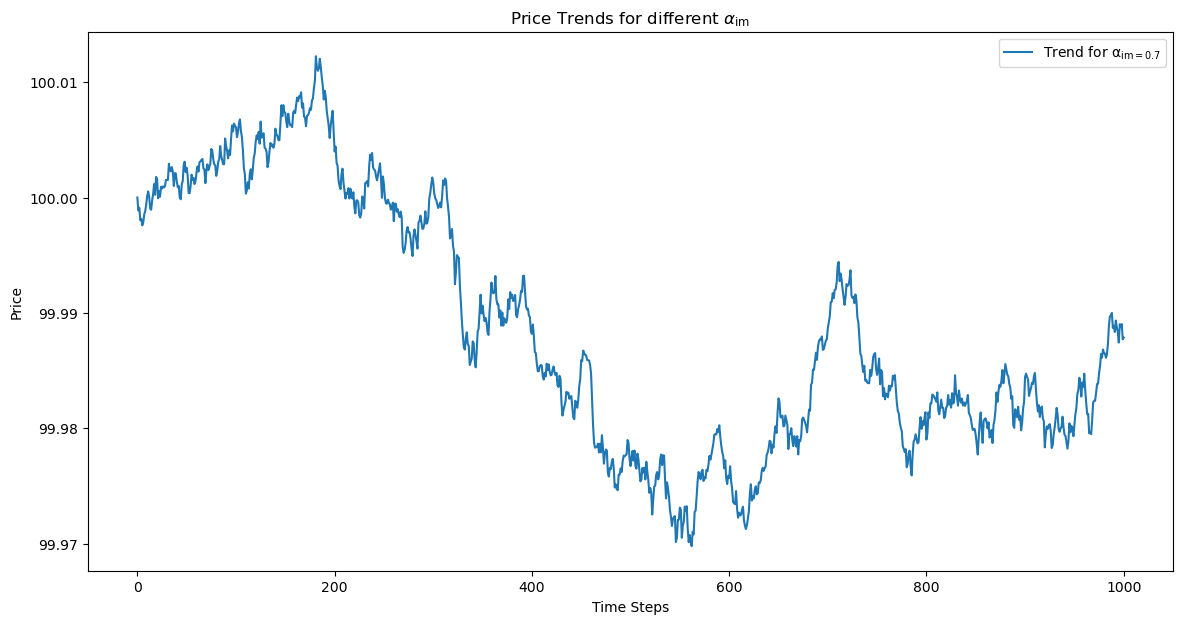

In [334]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(14, 7))
for key, values in price_historys.items():
    plt.plot(values, label=r'Trend for $\mathrm{\alpha_{im=' + str(key) + '}}$')
plt.title(r'Price Trends for different $\alpha_{\mathrm{im}}$')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend()
plt.show()